## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

%matplotlib inline

/Users/gaelphilippe/.pyenv/versions/3.5.6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams("distributed_run=False,mask_padding=False")
hparams.sampling_rate = 22050
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024

INFO:tensorflow:Parsing command line hparams: distributed_run=False,mask_padding=False


#### Load model from checkpoint

In [19]:
checkpoint_path = "/Users/gaelphilippe/IdeaProjects/parallel_tacotron2/output/checkpoint_12500"
model = load_model(hparams)
try:
    model = model.module
except:
    pass
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path, map_location="cpu")['state_dict'].items()})
_ = model.eval()

{} Cuda devices 0


#### Prepare text input

In [20]:
text = "You stay in Wonderland and I show you how deep the rabbit hole goes."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cpu().long()

#### Decode text input and plot results

100%|██████████| 3/3 [00:00<00:00, 88.67it/s]


Warning! Reached max decoder steps
tensor([[[-7.5690e-01, -5.4216e-03, -7.5355e-01,  ...,  1.5751e-03,
           1.0892e-02, -9.9111e-03],
         [ 9.7146e-02,  1.1527e-03, -5.1729e-03,  ...,  4.0947e-03,
           6.9555e-02, -1.1162e-02],
         [ 6.1277e-02,  3.4794e-02, -5.8064e-03,  ..., -8.1004e-03,
           6.3428e-02,  9.1903e-03],
         ...,
         [ 2.3964e-03,  5.2797e-02,  8.3156e-04,  ...,  3.7357e-03,
           2.5993e-01, -1.9787e-02],
         [ 1.0226e-02, -1.2056e-02,  3.4374e-03,  ...,  4.8051e-03,
           5.8911e-03, -6.7149e-03],
         [ 1.9629e-02, -1.3793e-01,  1.5958e-02,  ...,  4.3363e-03,
          -1.0362e-01, -7.1881e-02]]], grad_fn=<TransposeBackward0>)
torch.Size([1, 80, 1000]) torch.Size([1, 80, 1000])


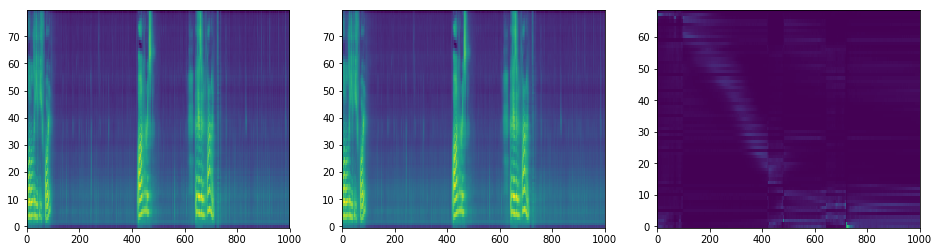

In [21]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Load TacotronSTFT and convert mel-spectrogram to spectrogram

In [13]:
print(mel_outputs_postnet.size())
taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

print(spec_from_mel.size())

torch.Size([1, 80, 1000])
torch.Size([1, 513, 1000])


#### Synthesize audio from spectrogram using the Griffin-Lim algorithm

In [14]:
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 60)

100%|██████████| 60/60 [00:04<00:00, 14.37it/s]


In [15]:
ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate) 